In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import numpy as np

In [4]:
#Bring in Data
df_raw = pd.read_csv('../RainGarden.csv')
df_raw.shape

(14889, 4)

In [5]:
# NOTE why the author only loads this portion of data?
df_f = df_raw.iloc[7000:10000]
df_f.head()

,Time,wfv_1,wfv_2,wfv_3
7000,6/4/22 8:45,23.476951,20.388335,20.142405
7001,6/4/22 9:00,23.476951,20.302906,20.142405
7002,6/4/22 9:15,23.367694,20.106473,20.142405
7003,6/4/22 9:30,23.636009,20.106473,20.142405
7004,6/4/22 9:45,23.364815,20.018843,20.140844


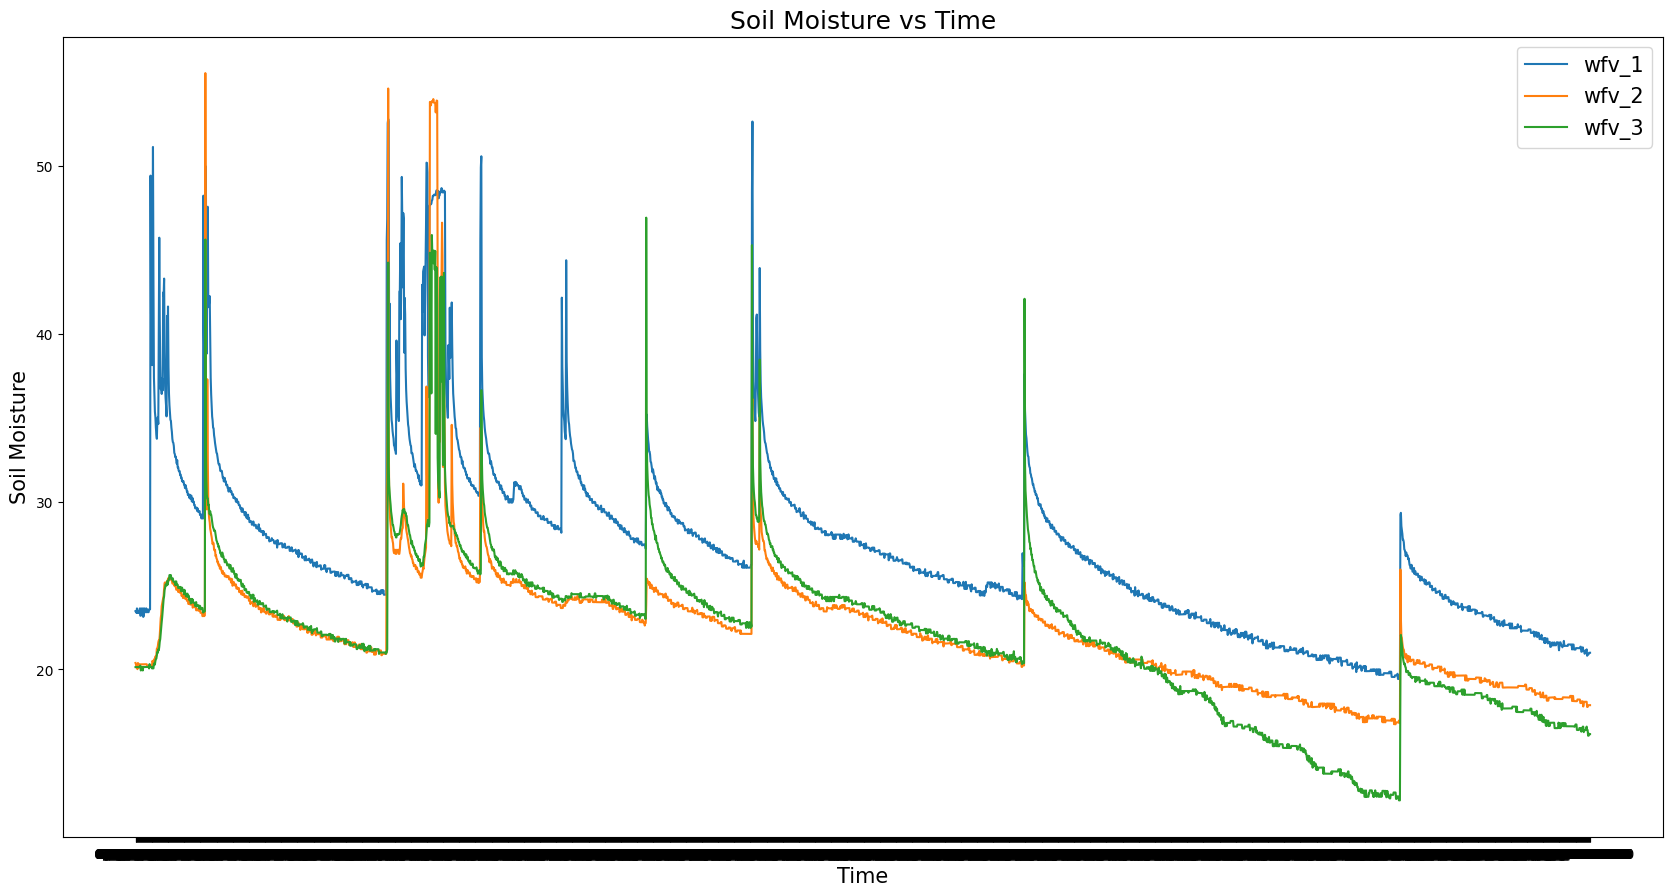

In [6]:
#Plot Data. 
#Each soil sensor is measuring percent moisture at 16 cm below surface. 
x = df_f['Time']
y_1 = df_f['wfv_1']
y_2 = df_f['wfv_2']
y_3 = df_f['wfv_3']

fig = plt.figure(figsize=(16,8))
axes_4 = fig.add_axes([0,0,1,1]) #this means you want the whole array
axes_4.set_xlabel('Time' ,fontsize=15,) 
axes_4.set_ylabel('Soil Moisture',fontsize=15)
axes_4.set_title('Soil Moisture vs Time',fontsize=18)
axes_4.plot(x, y_1, label='wfv_1')
axes_4.plot(x, y_2, label='wfv_2')
axes_4.plot(x, y_3, label='wfv_3')
axes_4.legend(loc='best',fontsize=15)

plt.show()

In [46]:
log_y_1 = np.log(y_1)
log_y_2 = np.log(y_2)
log_y_3 = np.log(y_3)

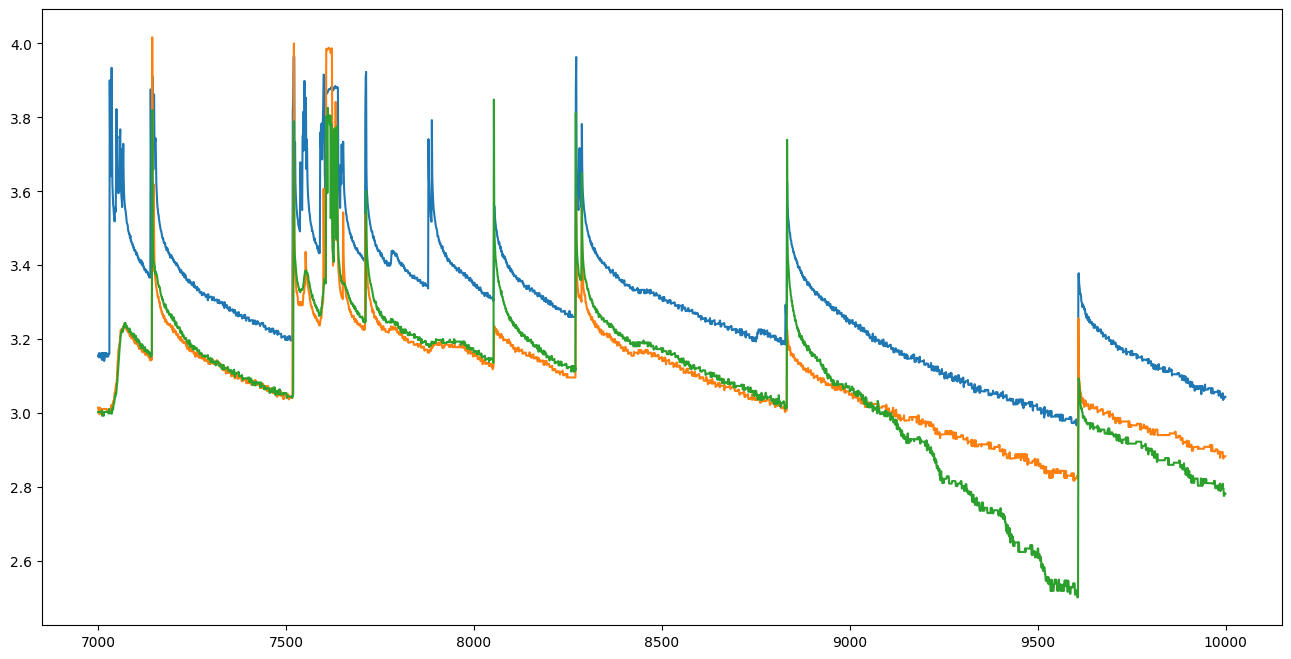

In [47]:
fig = plt.figure(figsize=(16,8))
plt.plot(log_y_1)
plt.plot(log_y_2)
plt.plot(log_y_3)
plt.show()

In [48]:
key, subkey = jr.split(key)
x = np.arange(3000) * 15.0
x_train = (np.arange(1500) * 30.0).reshape(-1,1)
# x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
# y = signal + jr.normal(subkey, shape=signal.shape) * noise
y_train = (np.array(log_y_2.iloc[::2])).reshape(-1,1)
x_test = (np.arange(1500) * 30.0 + 15).reshape(-1,1)
y_test = (np.array(log_y_2.iloc[1::2])).reshape(-1,1)
D = gpx.Dataset(X=x_train, y=y_train)

In [50]:


mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF(lengthscale=15.0)
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood

In [51]:
print(-gpx.objectives.conjugate_mll(posterior, D)) # before training
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    # we use the negative mll as we are minimising
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

5062.637881052916
         Current function value: -2456.719592
         Iterations: 30
         Function evaluations: 82
         Gradient evaluations: 70
-2456.7195915480065


/opt/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [52]:
opt_posterior.prior.kernel.lengthscale

PositiveReal(
  _tag='positive',
  value=Array(217.65045997, dtype=float64)
)

In [53]:
latent_dist = opt_posterior.predict(x_train, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

Text(0.5, 1.0, '')

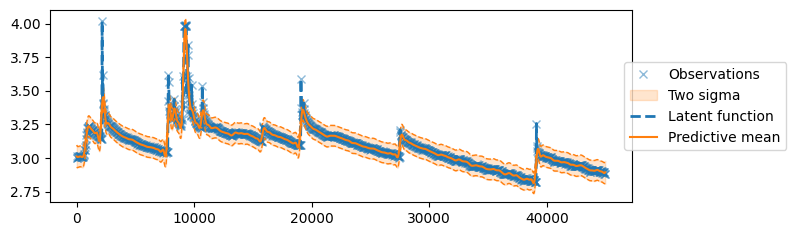

In [54]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x_train, y_train, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    x_train.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    x_train,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_train,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_train, y_train, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(x_train, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
ax.title

In [55]:
latent_dist = opt_posterior.predict(x_test, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

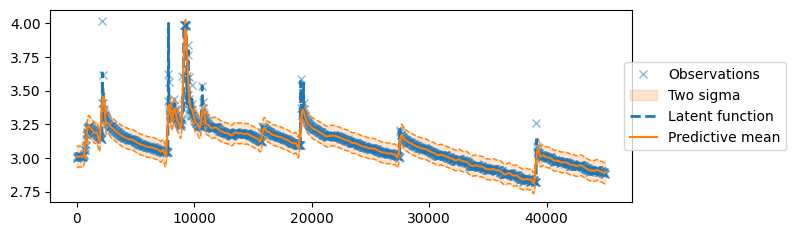

In [56]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x_train, y_train, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    x_test.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    x_test, y_test, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

In [68]:
samples = predictive_dist.sample(seed=key, sample_shape=(1,))

In [76]:
# step 1: sample a process from the posterior
# step 2: exponential transformation
# step 3: from data to estimate

from scipy.stats import linregress

def estimate_fc(x, y):
    """
    Params:
        x: a numpy array of time points
        y: a numpy array of moisture level
    Returns:
        fc_df: a pd Dataframe that contains the time 
    """
    def get_slope(array):
        y = np.array(array)
        x = np.arange(len(y))
        slope, intercept, r_value, p_value, std_err = linregress(x,y)
        return slope
    time_frame = 7 # TODO change this to optimal lengthscale/interval
    std_frame = 3
    minmaxframe = 10 # TODO what does this mean?
    df = pd.DataFrame({'t': x, 'y': y}) 
    df['rolling_slope'] = df['y'].rolling(window=time_frame, center=True,
                                min_periods=time_frame).apply(get_slope)

    #get rolling min max difference
    df['minmaxdif'] = (df['rolling_slope'].rolling(window=minmaxframe,center=False).max())-(df['rolling_slope'].rolling(window=minmaxframe,center=False).min())
    df['rstd'] = df['y'].rolling(window=std_frame).std()

    fc_df = df.loc[(df['rolling_slope']<-0.05 )& 
                (df['minmaxdif']<.05) & (df['rolling_slope']>-0.1)]
    # TODO throw away the sample if len(fc_df) is too small
    fc = fc_df['y'].mean()

    return fc_df


(1500,) (1500,)
0


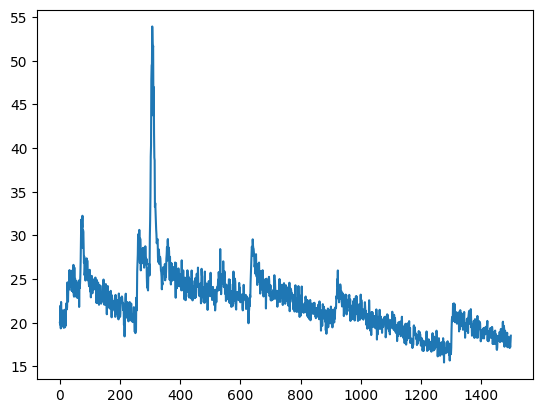

(1500,) (1500,)
0


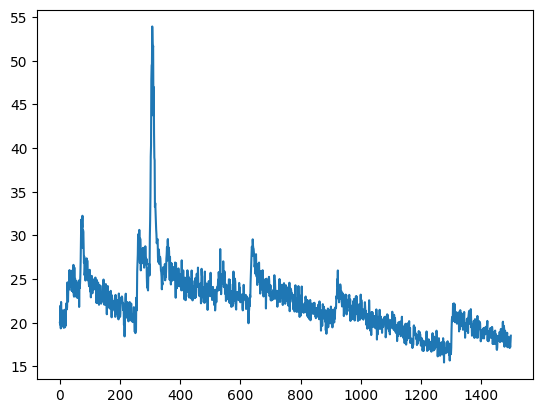

(1500,) (1500,)
0


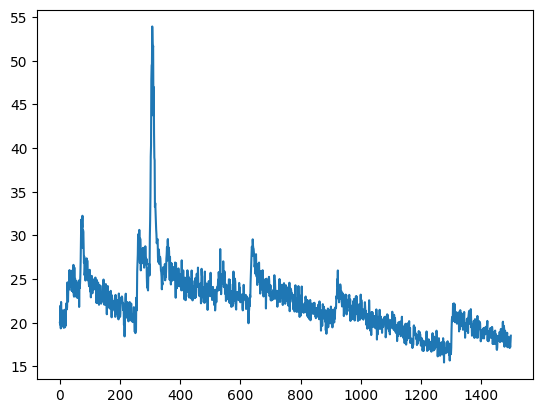

(1500,) (1500,)
0


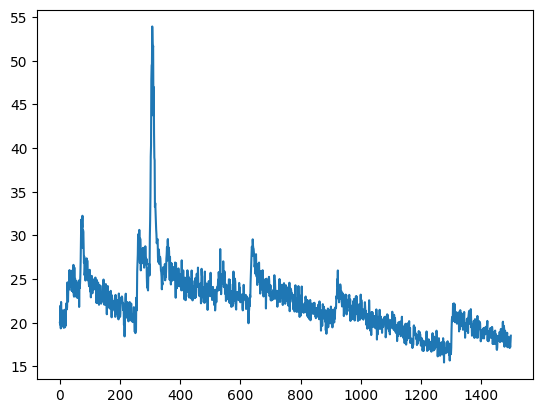

(1500,) (1500,)
0


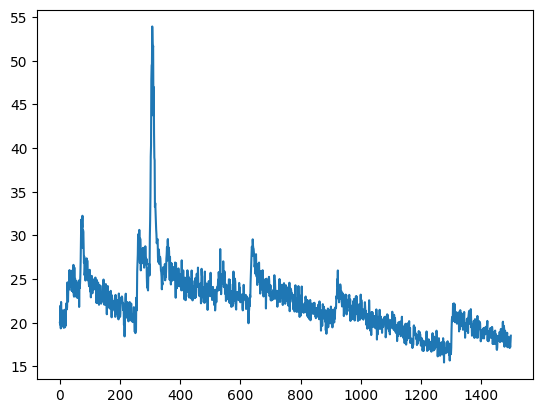

(1500,) (1500,)
0


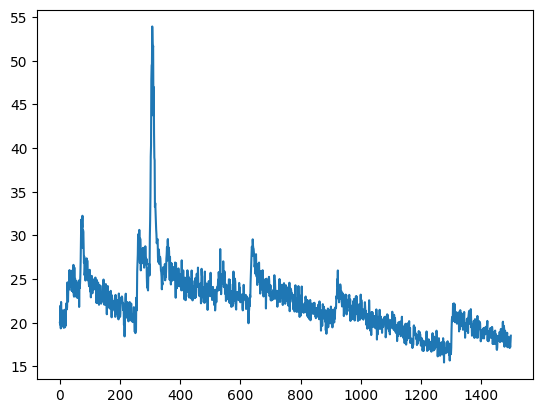

(1500,) (1500,)
0


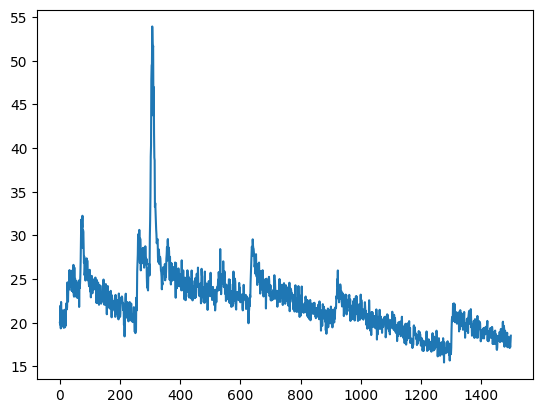

(1500,) (1500,)
0


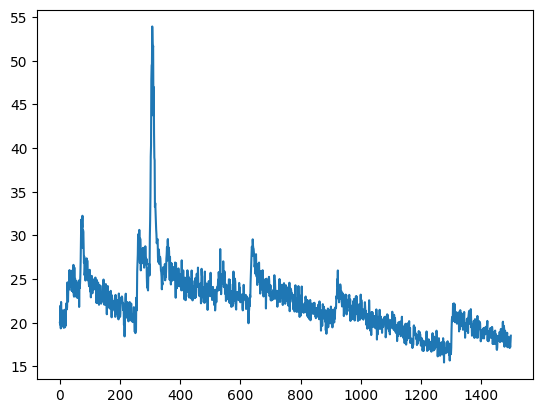

(1500,) (1500,)
0


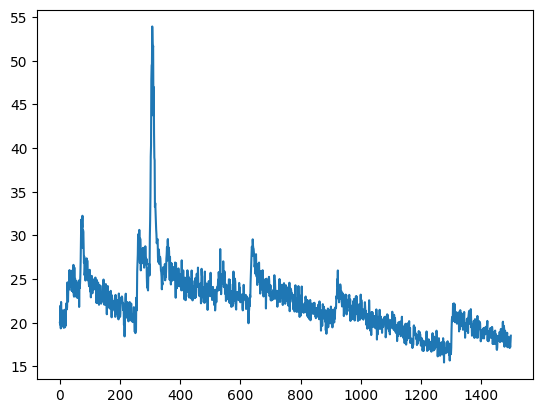

(1500,) (1500,)
0


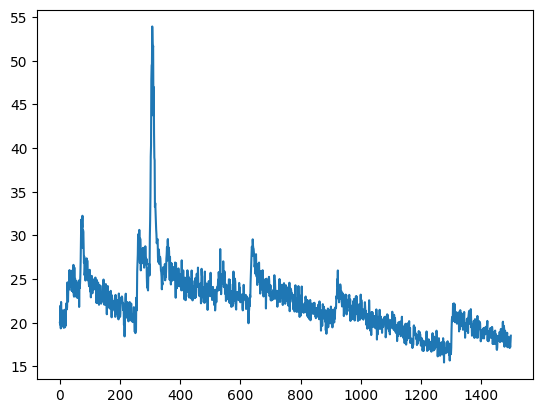

(1500,) (1500,)
0


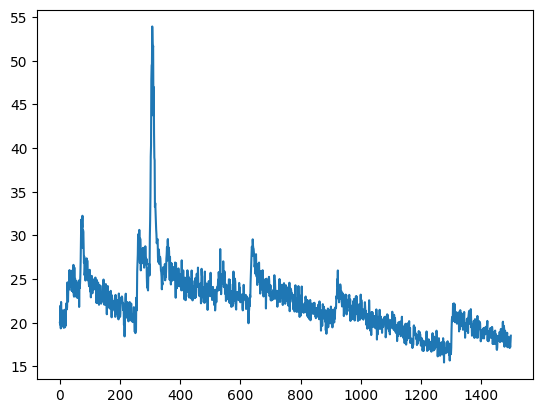

(1500,) (1500,)
0


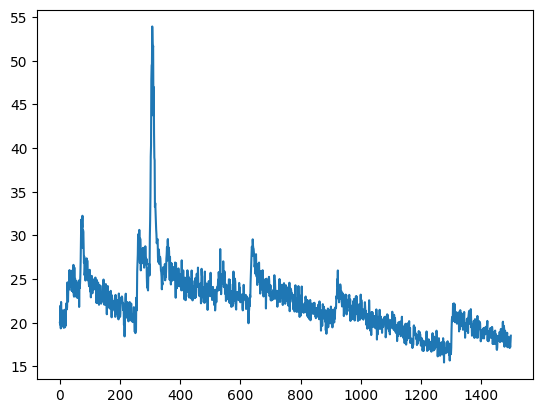

(1500,) (1500,)
0


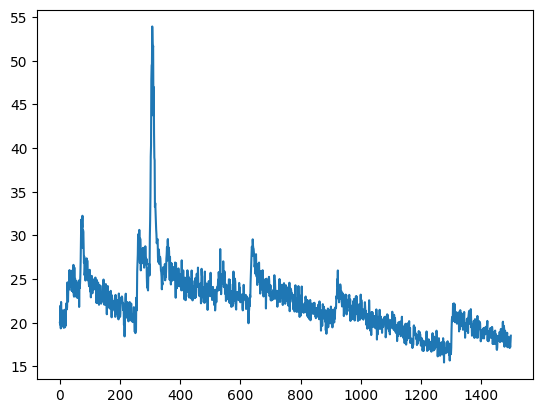

(1500,) (1500,)
0


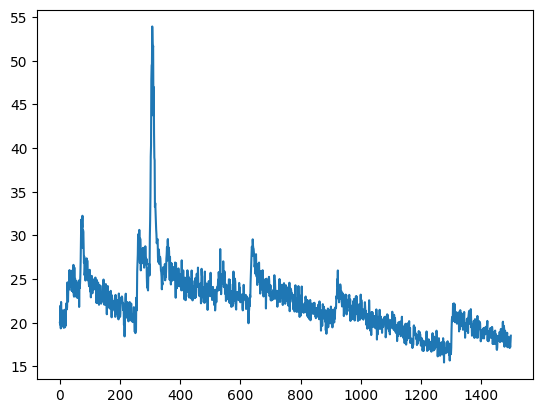

(1500,) (1500,)
0


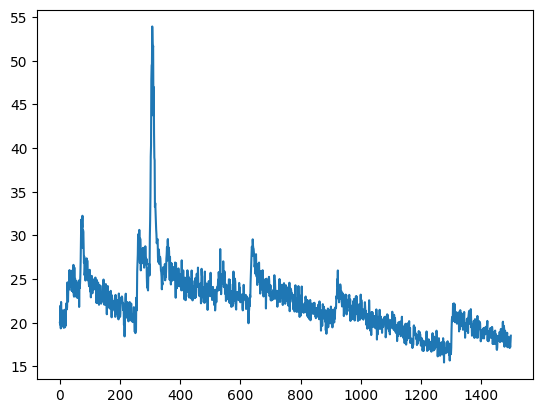

(1500,) (1500,)
0


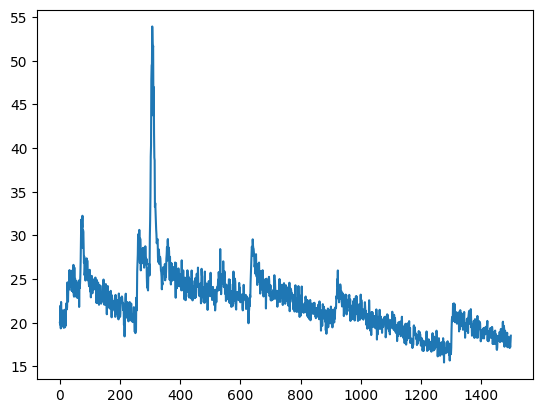

(1500,) (1500,)
0


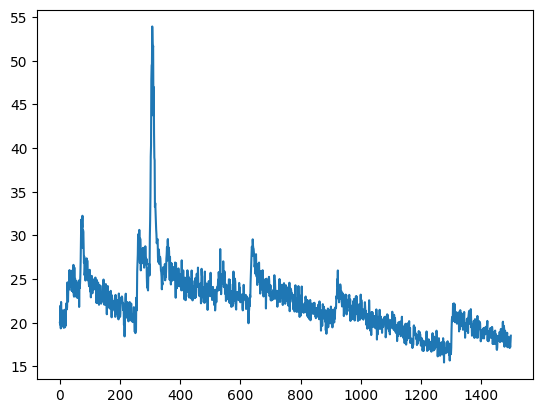

(1500,) (1500,)
0


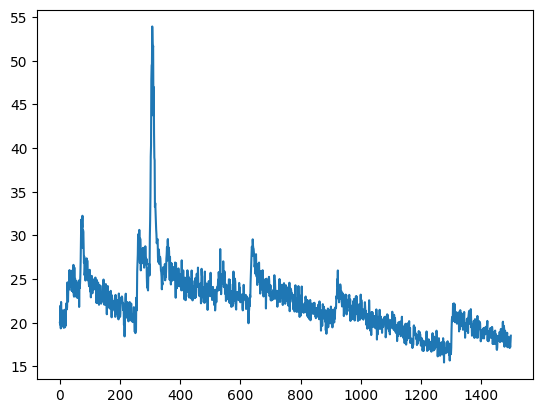

(1500,) (1500,)
0


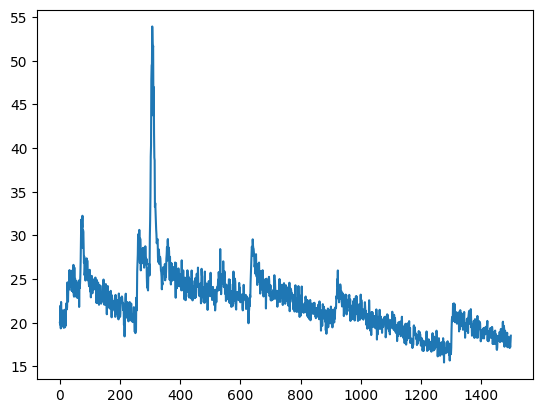

(1500,) (1500,)
0


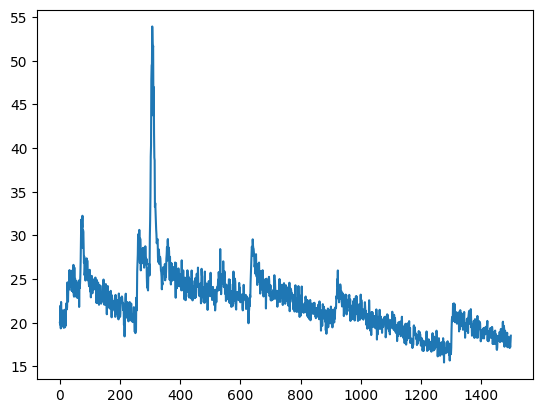

(1500,) (1500,)
0


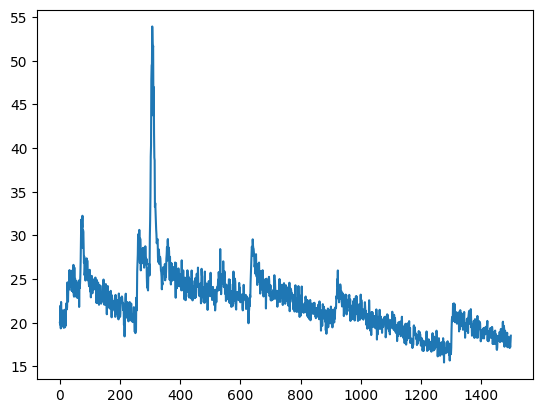

(1500,) (1500,)
0


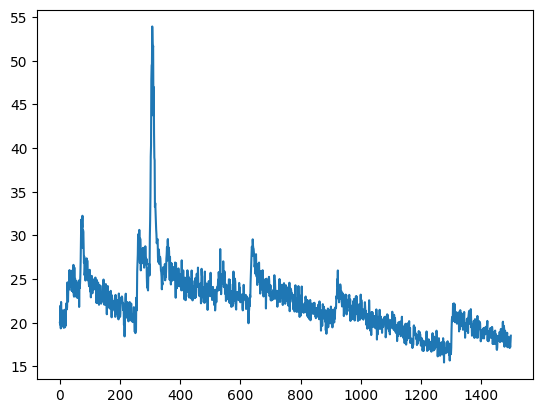

(1500,) (1500,)
0


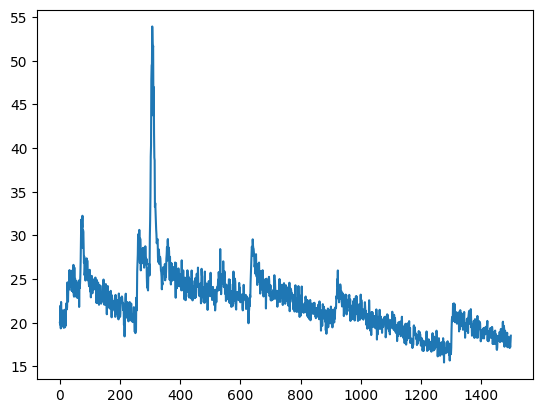

(1500,) (1500,)
0


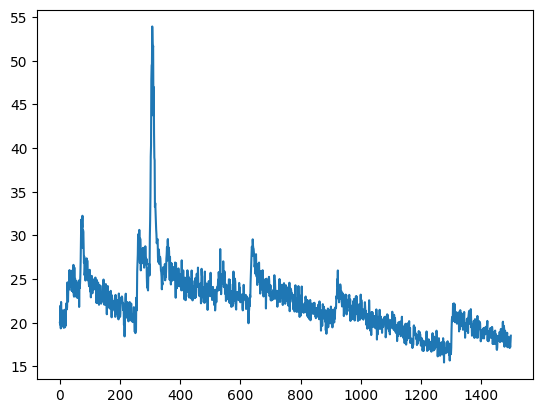

(1500,) (1500,)
0


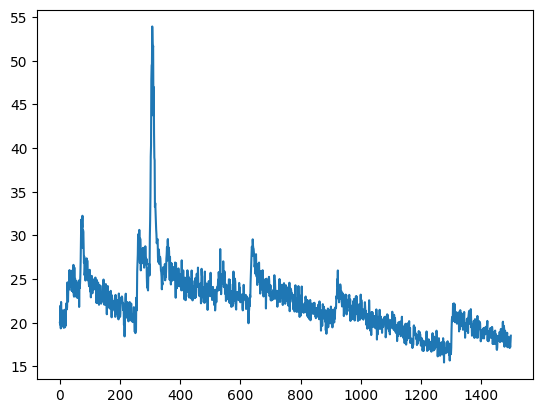

(1500,) (1500,)
0


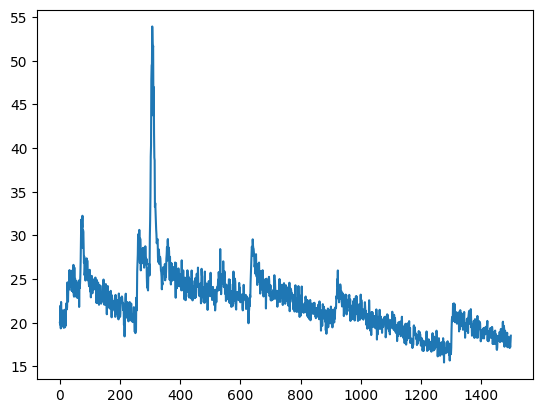

(1500,) (1500,)
0


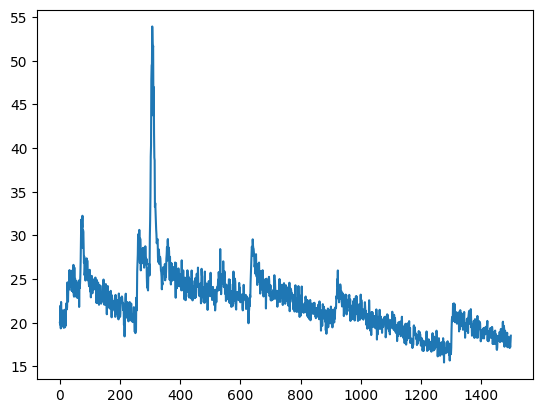

(1500,) (1500,)
0


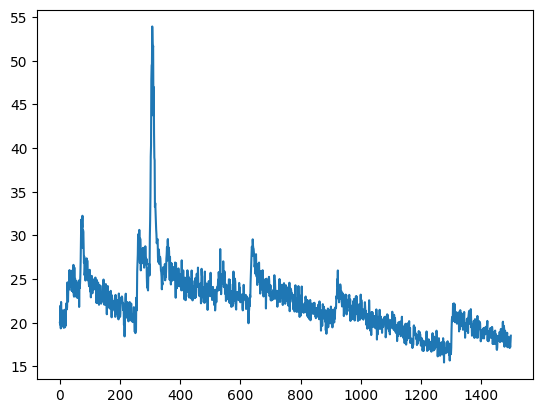

(1500,) (1500,)
0


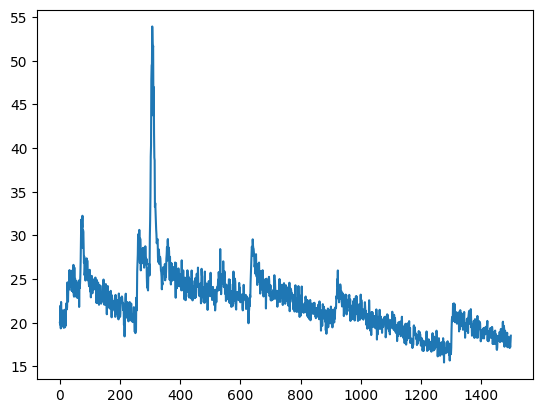

(1500,) (1500,)
0


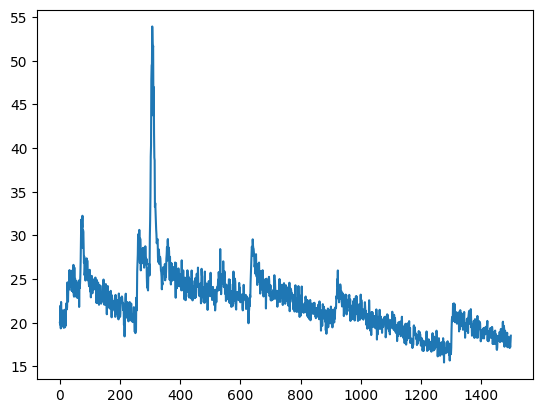

(1500,) (1500,)
0


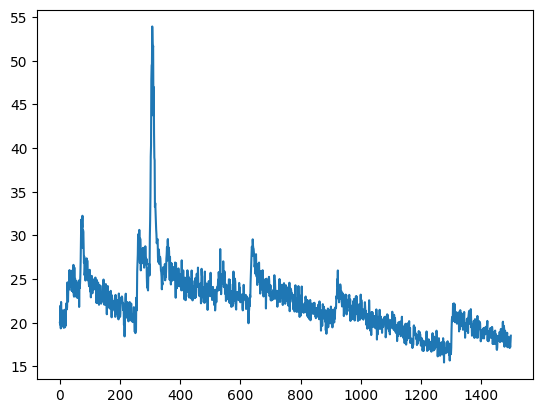

(1500,) (1500,)
0


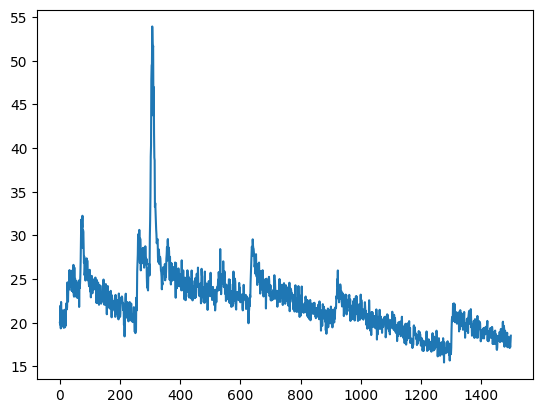

(1500,) (1500,)
0


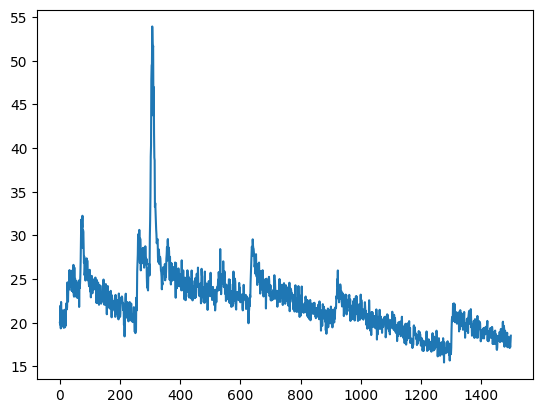

(1500,) (1500,)
0


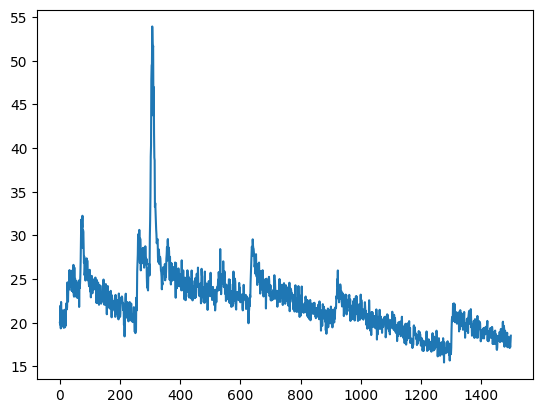

(1500,) (1500,)
0


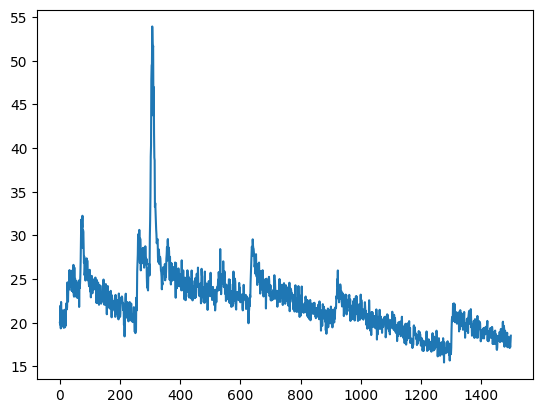

(1500,) (1500,)
0


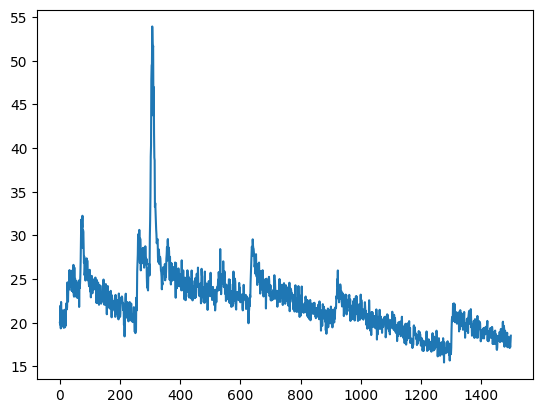

(1500,) (1500,)
0


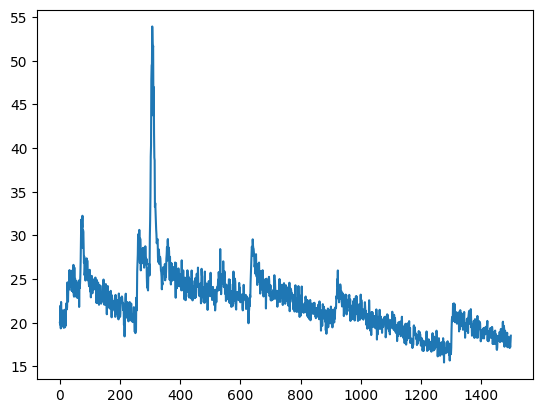

(1500,) (1500,)
0


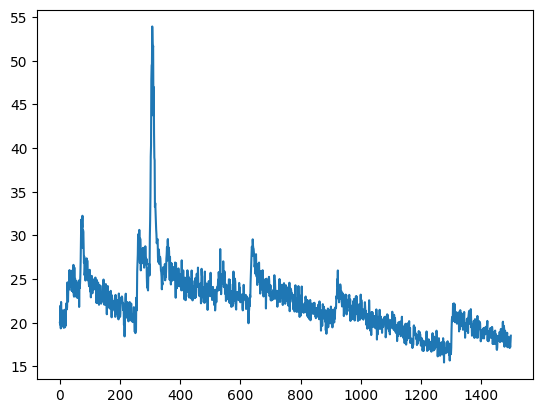

(1500,) (1500,)
0


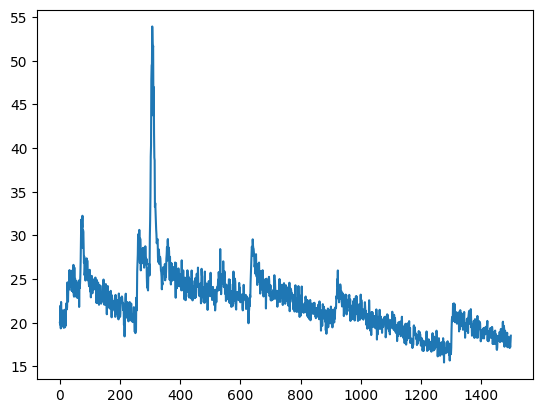

(1500,) (1500,)
0


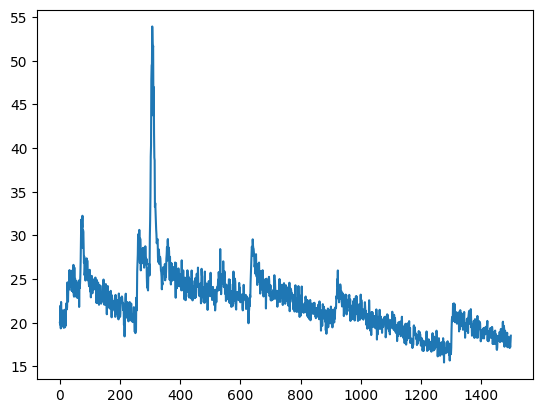

(1500,) (1500,)
0


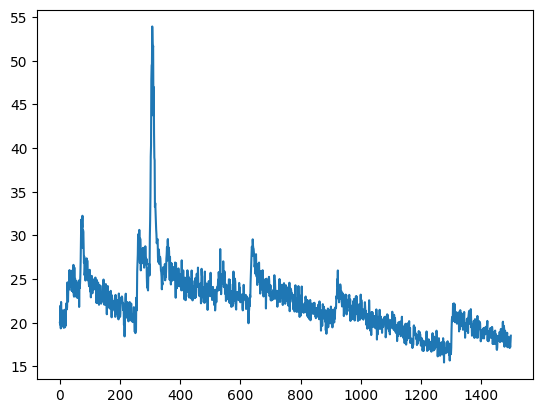

(1500,) (1500,)
0


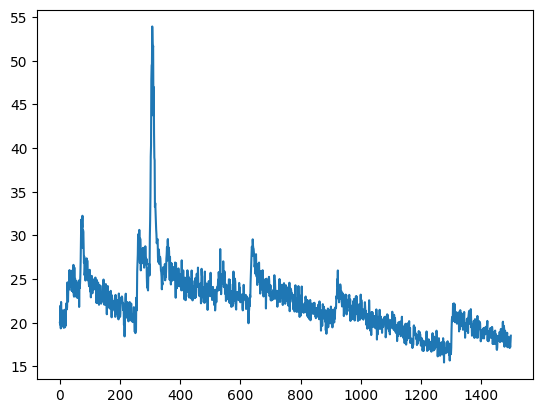

(1500,) (1500,)
0


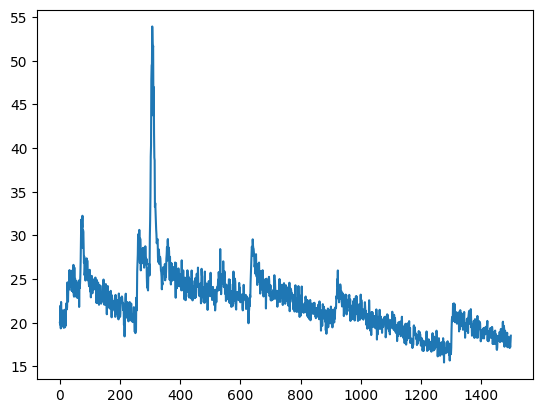

(1500,) (1500,)
0


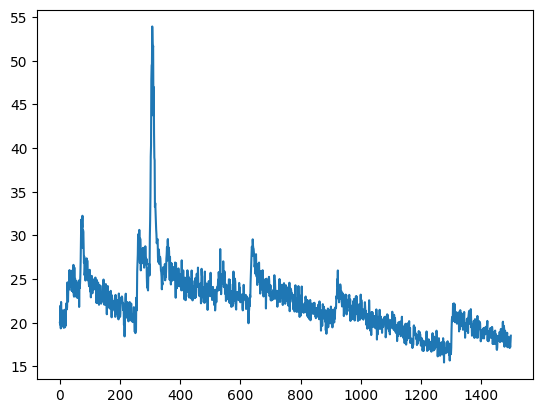

(1500,) (1500,)
0


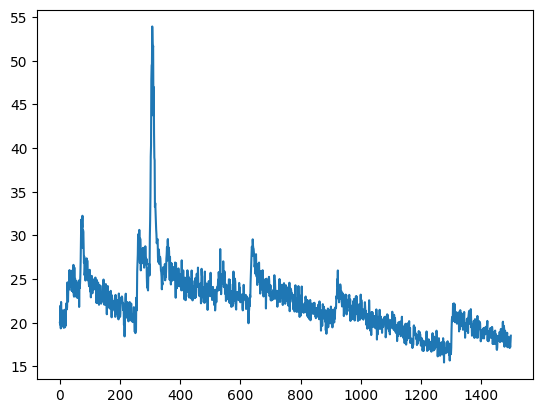

(1500,) (1500,)
0


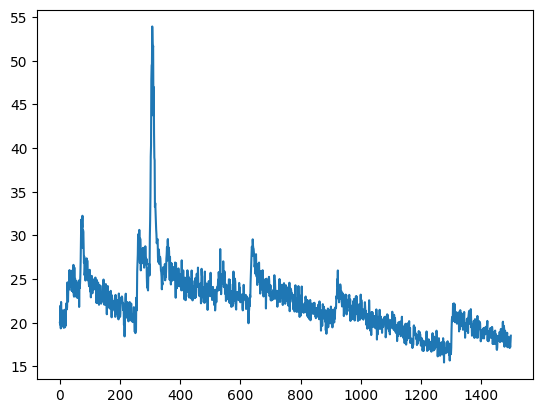

(1500,) (1500,)
0


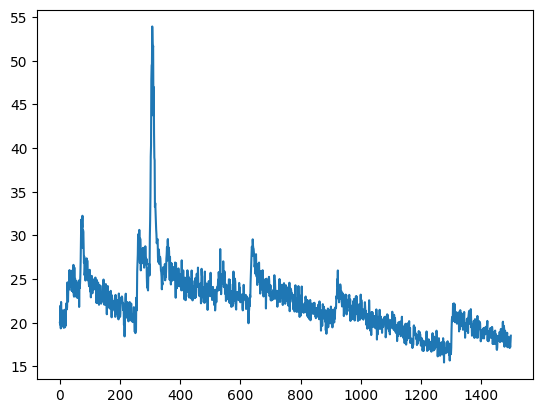

(1500,) (1500,)
0


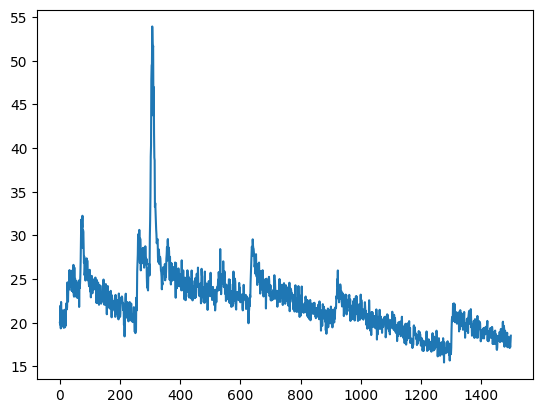

(1500,) (1500,)
0


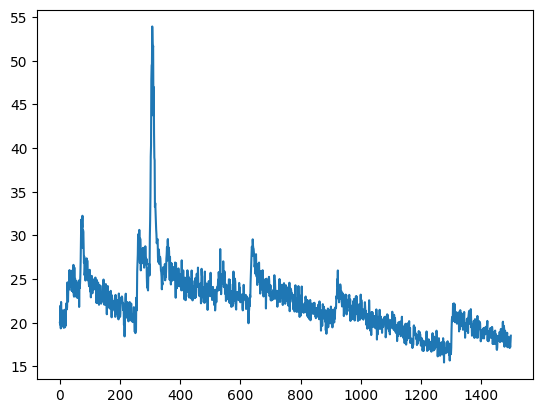

(1500,) (1500,)
0


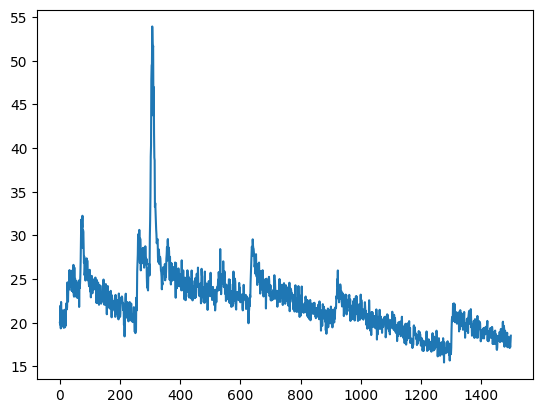

(1500,) (1500,)
0


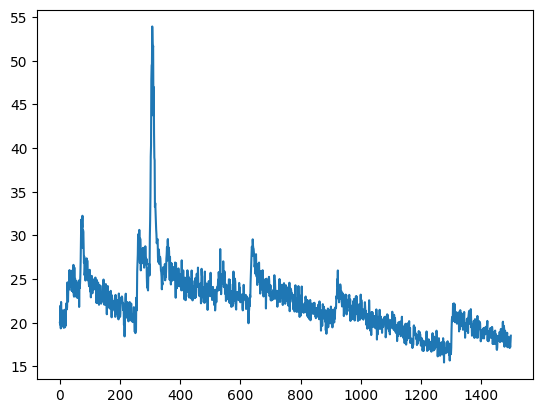

(1500,) (1500,)
0


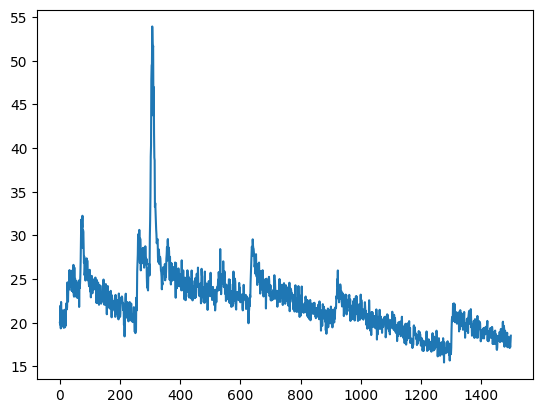

(1500,) (1500,)
0


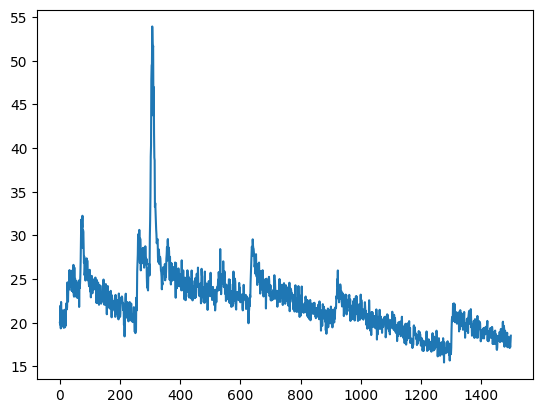

(1500,) (1500,)
0


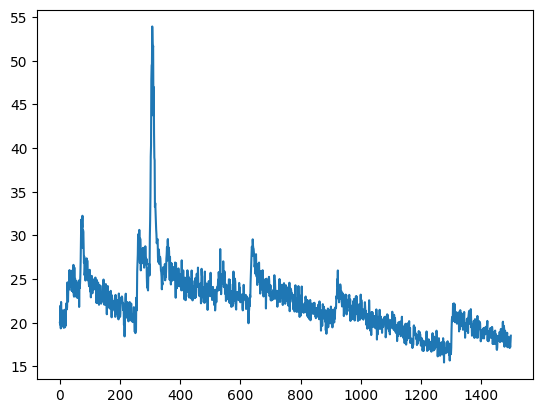

(1500,) (1500,)
0


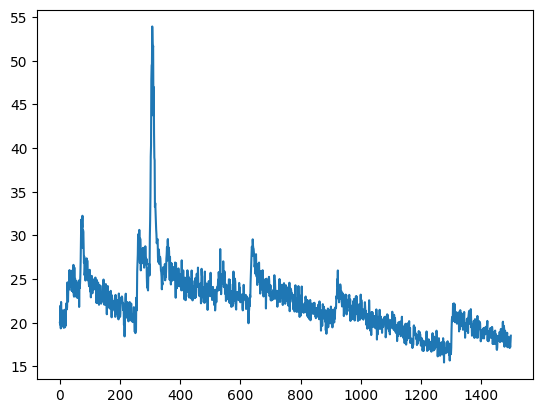

(1500,) (1500,)
0


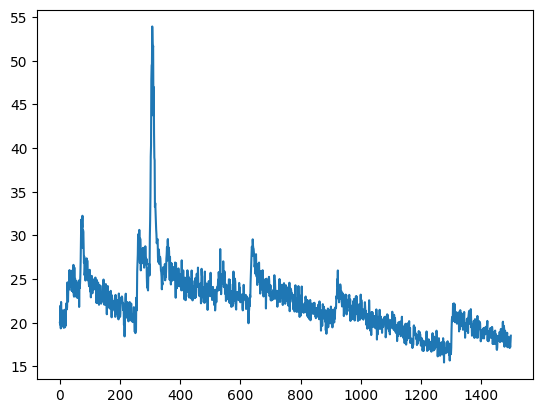

(1500,) (1500,)
0


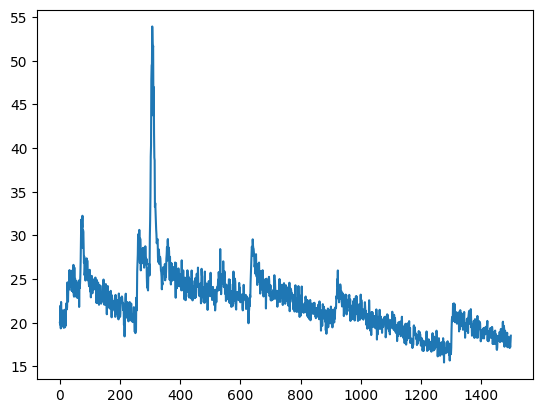

(1500,) (1500,)
0


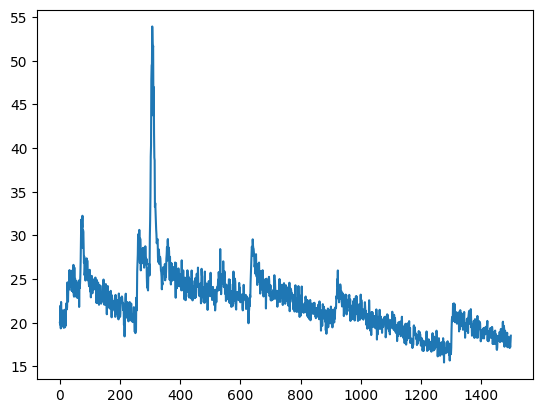

(1500,) (1500,)
0


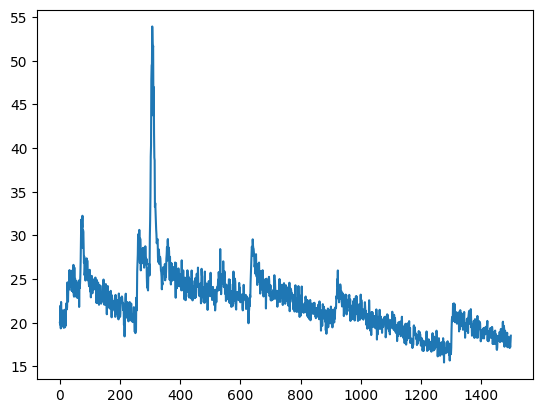

(1500,) (1500,)
0


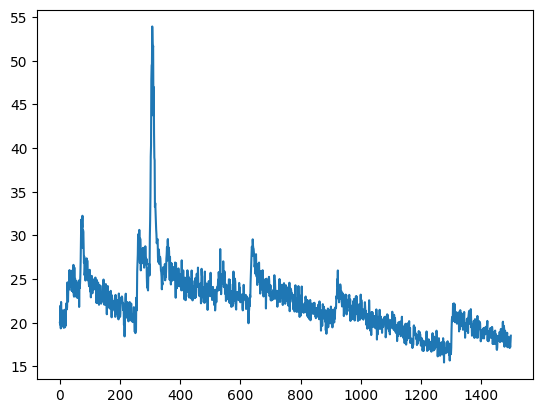

(1500,) (1500,)
0


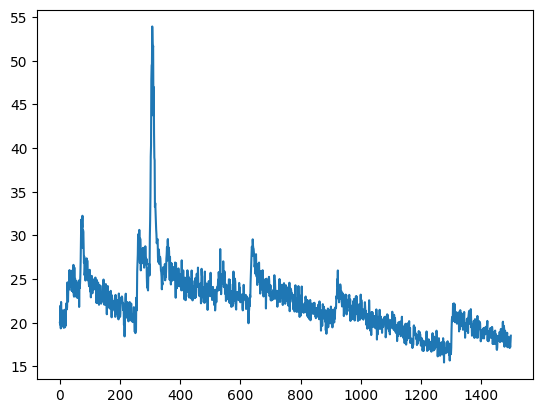

(1500,) (1500,)
0


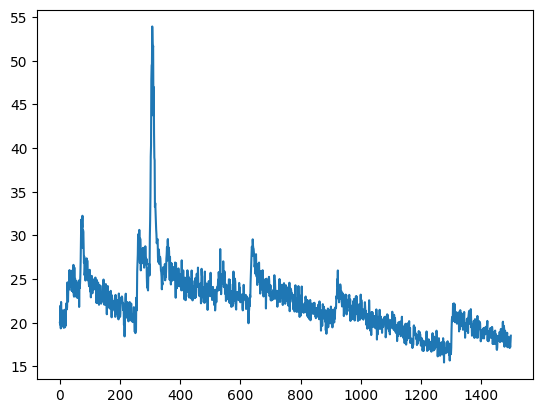

(1500,) (1500,)
0


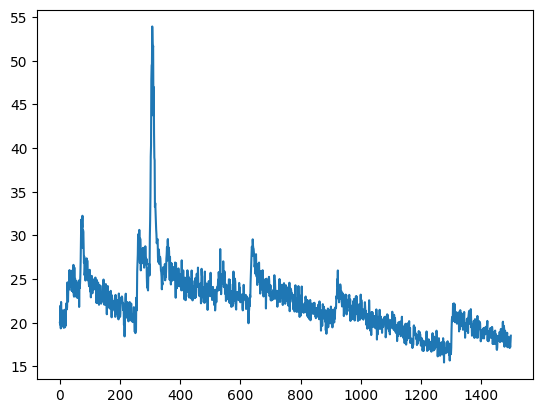

(1500,) (1500,)
0


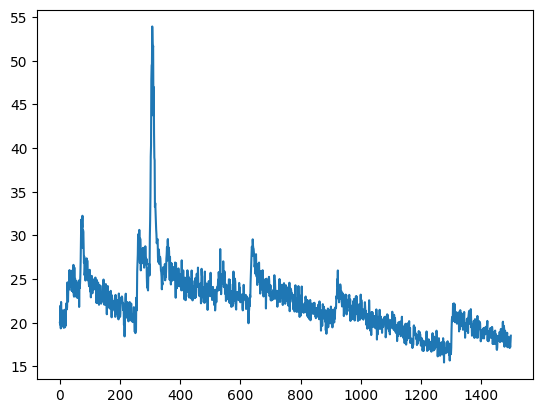

(1500,) (1500,)
0


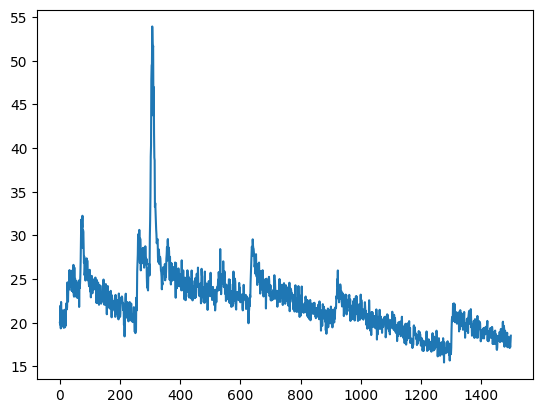

(1500,) (1500,)
0


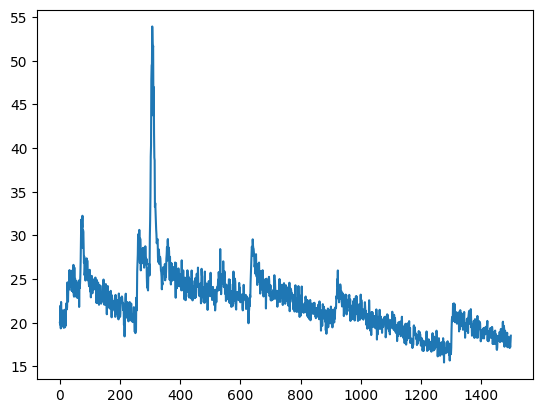

(1500,) (1500,)
0


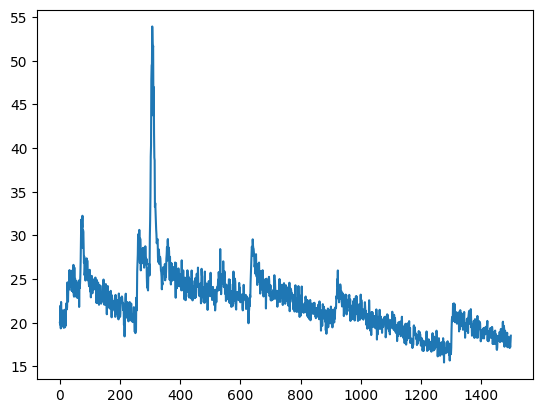

(1500,) (1500,)
0


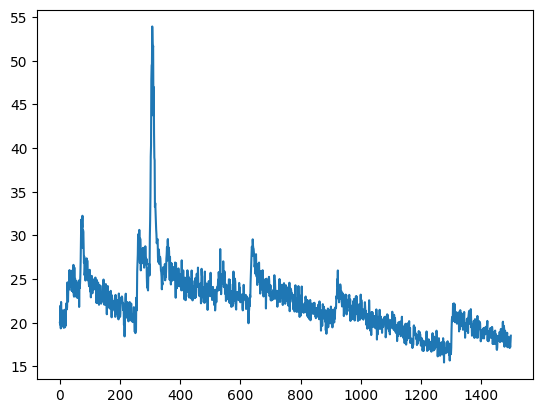

(1500,) (1500,)
0


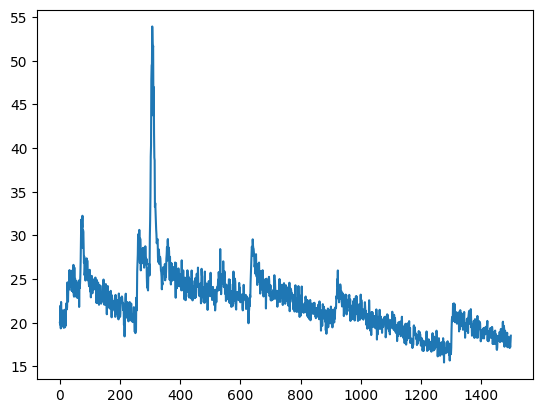

(1500,) (1500,)
0


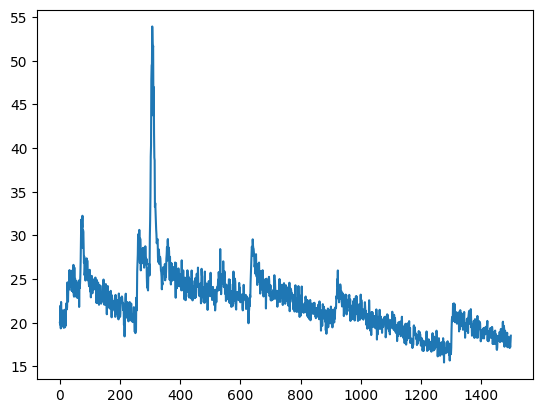

(1500,) (1500,)
0


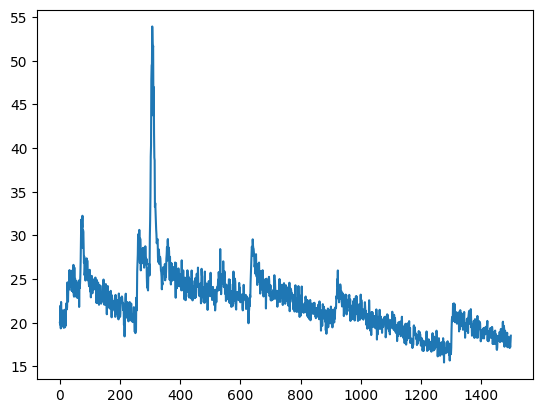

(1500,) (1500,)
0


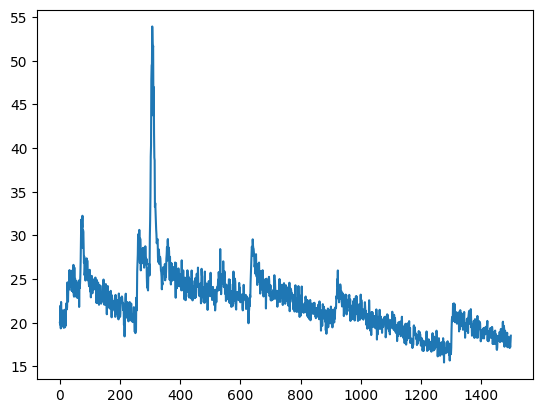

(1500,) (1500,)
0


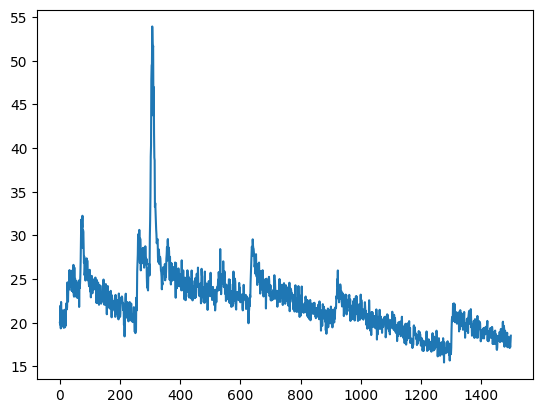

(1500,) (1500,)
0


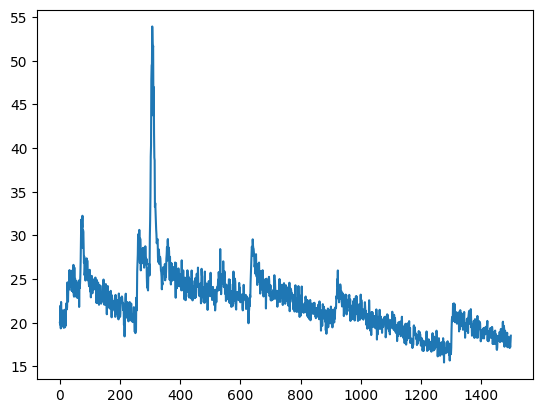

(1500,) (1500,)
0


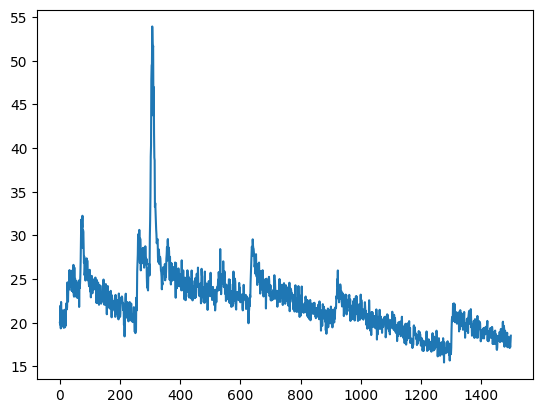

(1500,) (1500,)
0


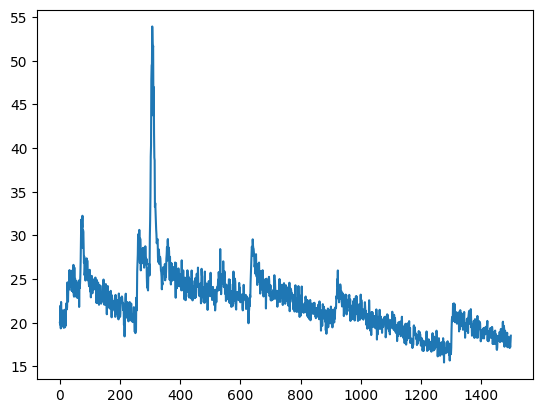

(1500,) (1500,)
0


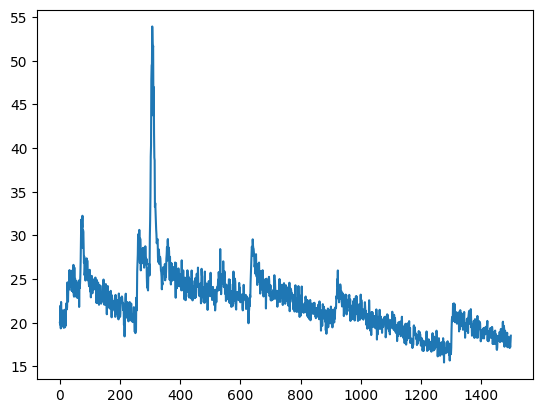

(1500,) (1500,)
0


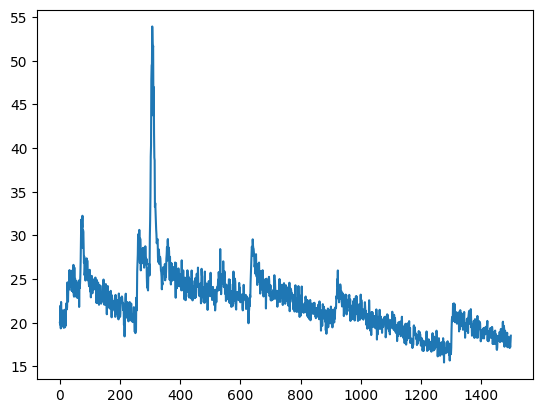

(1500,) (1500,)
0


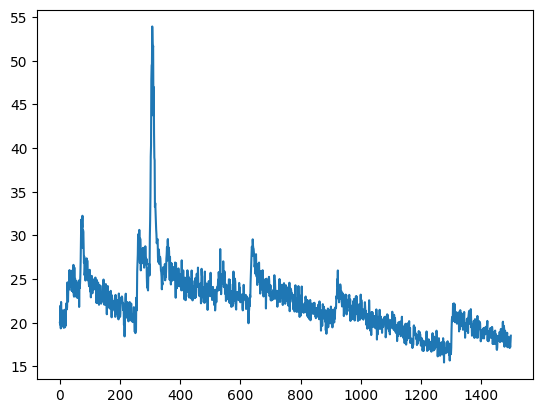

(1500,) (1500,)
0


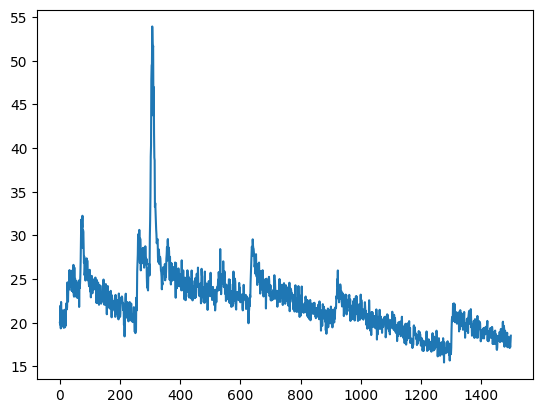

(1500,) (1500,)
0


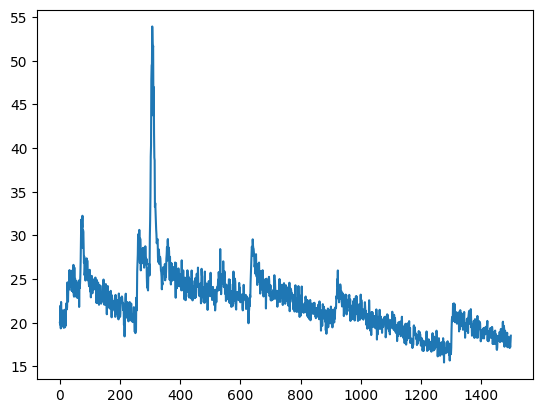

(1500,) (1500,)
0


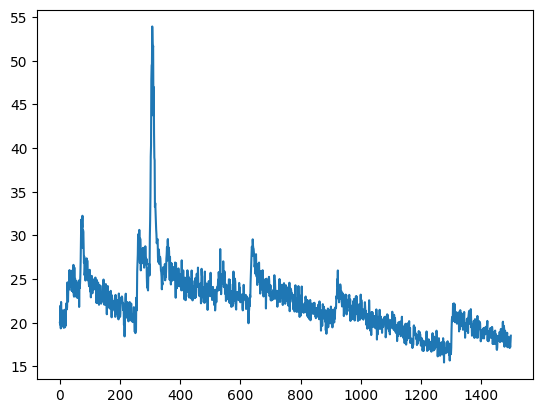

(1500,) (1500,)
0


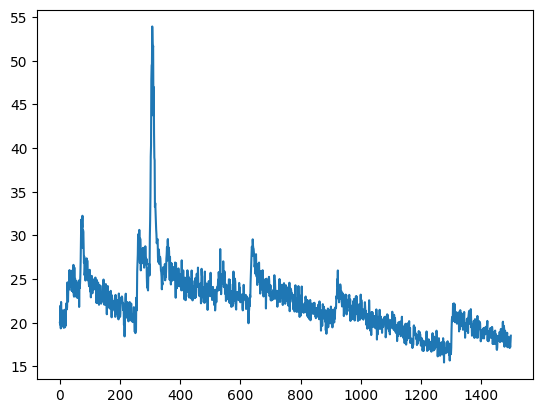

(1500,) (1500,)
0


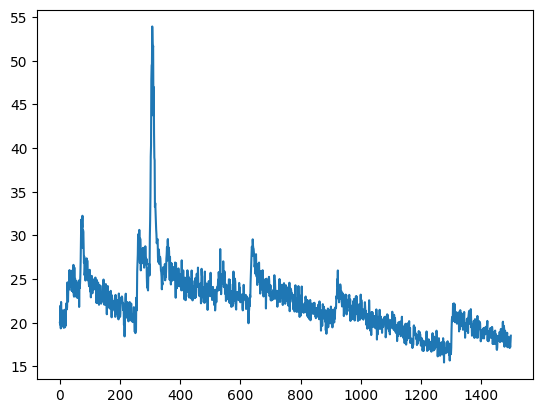

(1500,) (1500,)
0


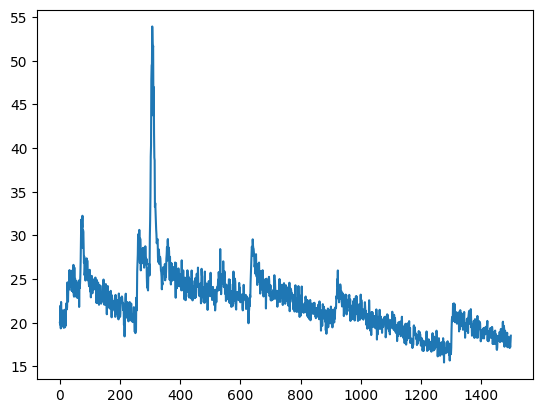

(1500,) (1500,)
0


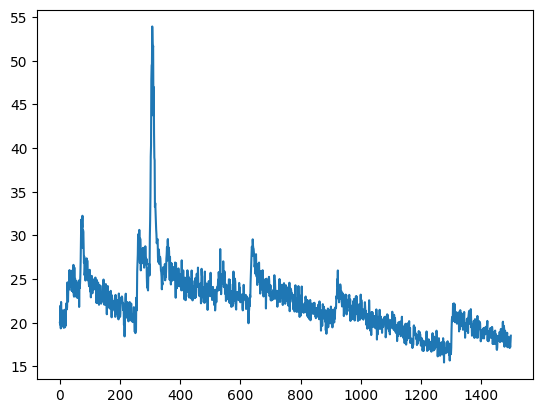

(1500,) (1500,)
0


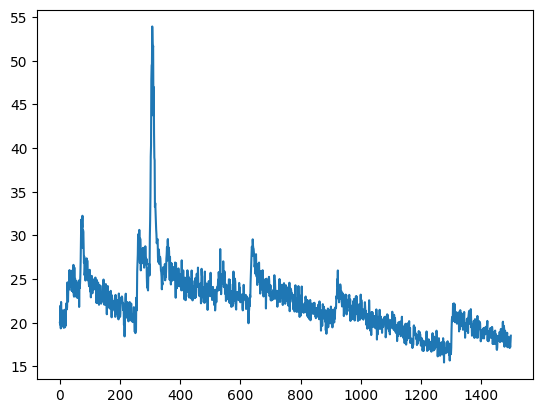

(1500,) (1500,)
0


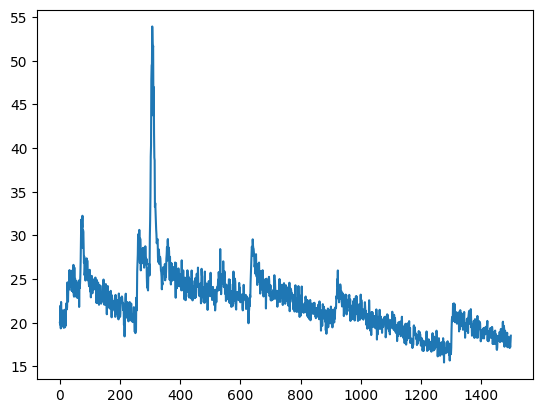

(1500,) (1500,)
0


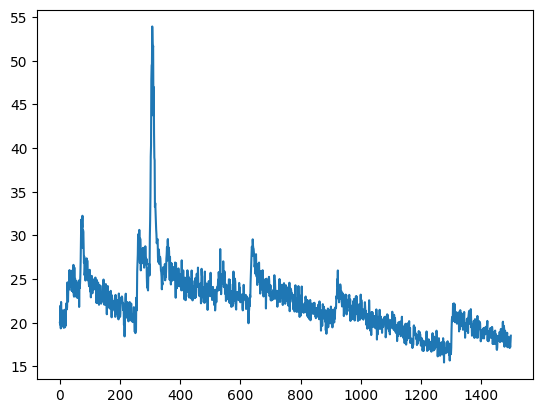

(1500,) (1500,)
0


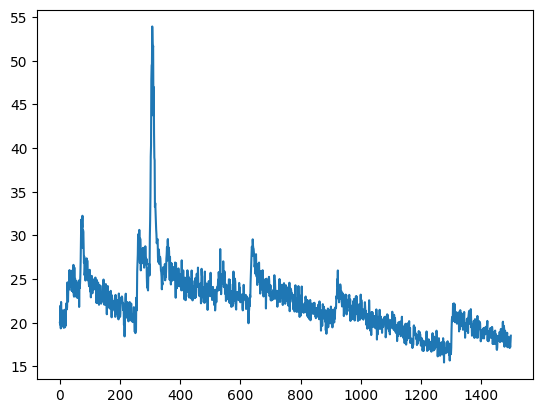

(1500,) (1500,)
0


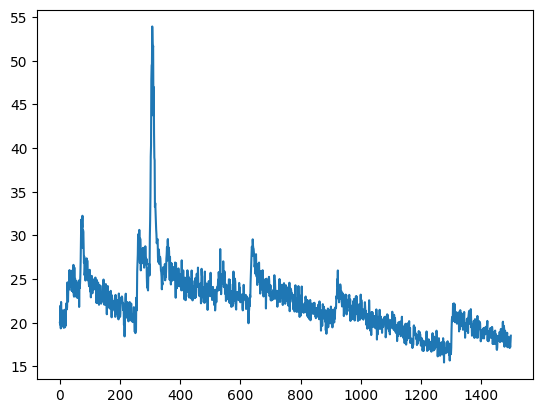

(1500,) (1500,)
0


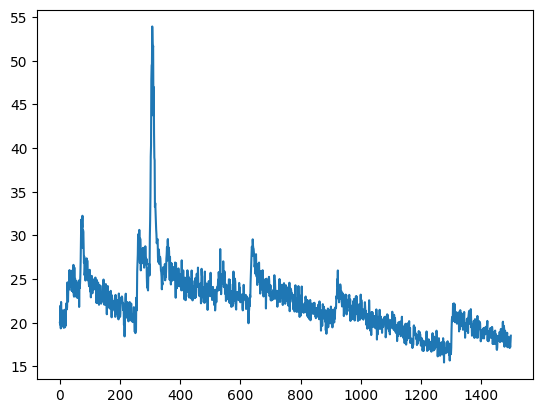

(1500,) (1500,)
0


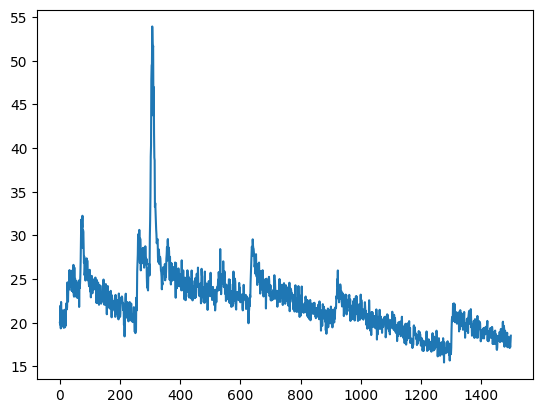

(1500,) (1500,)
0


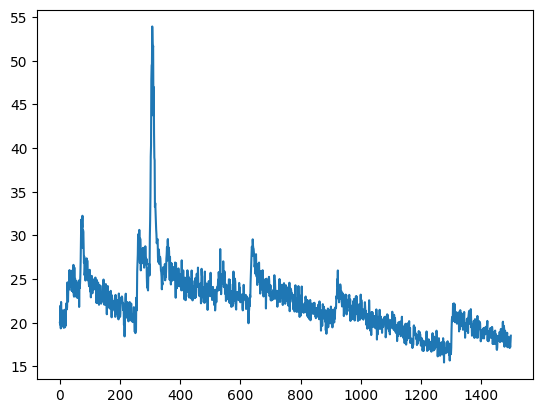

(1500,) (1500,)
0


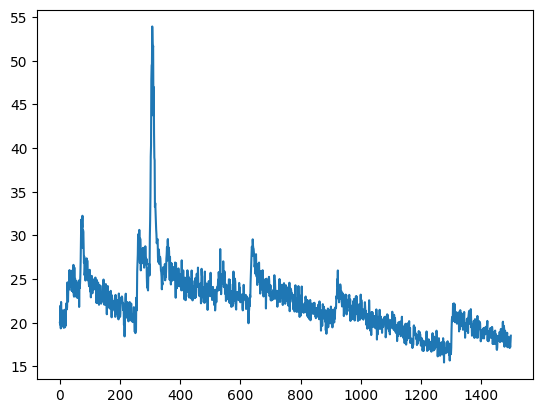

(1500,) (1500,)
0


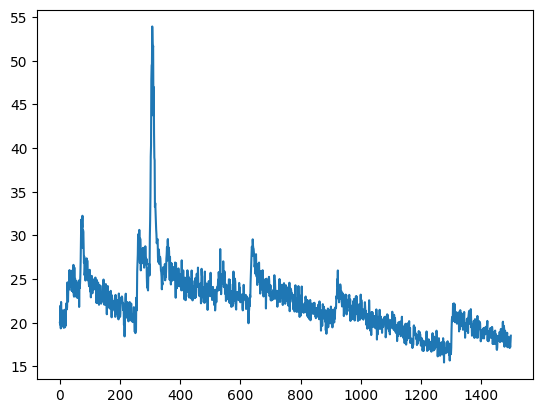

(1500,) (1500,)
0


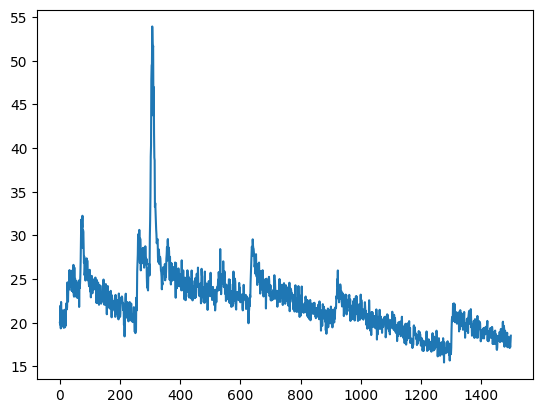

(1500,) (1500,)
0


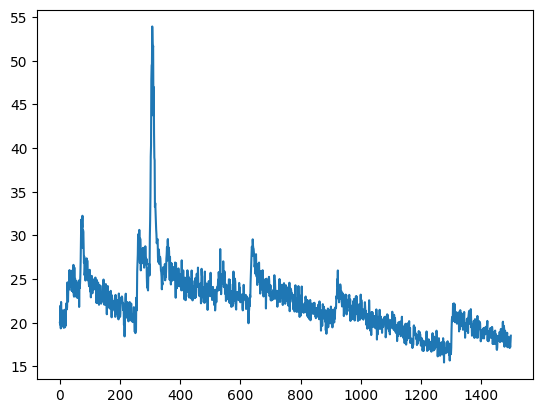

(1500,) (1500,)
0


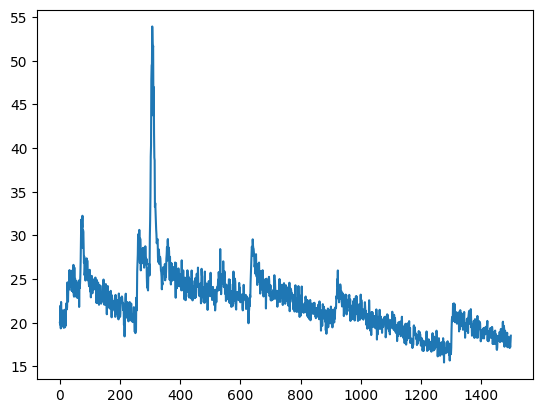

(1500,) (1500,)
0


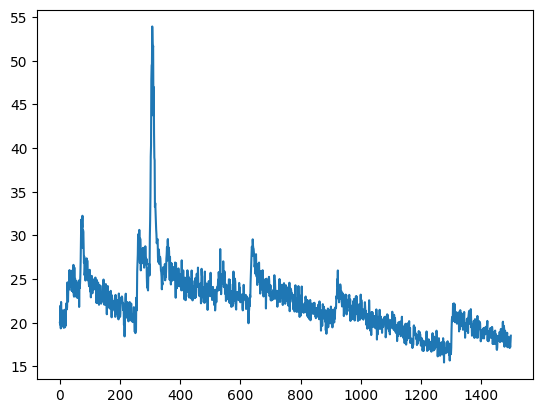

In [80]:
fc_sample = []
x_test = x_test.reshape(-1)
for i in range(100):
    s = predictive_dist.sample(seed=key, sample_shape=(1,)).T.reshape(-1) # TODO try sample without addictive noise
    s = jnp.exp(s)
    print(x_test.shape, s.shape)
    fc_df = estimate_fc(x_test, s)
    fc_sample.append(fc_df['y'].mean())
    print(len(fc_df)) # FIXME zero sample error
    plt.plot(s)
    plt.show()